### Advanced RAG agent

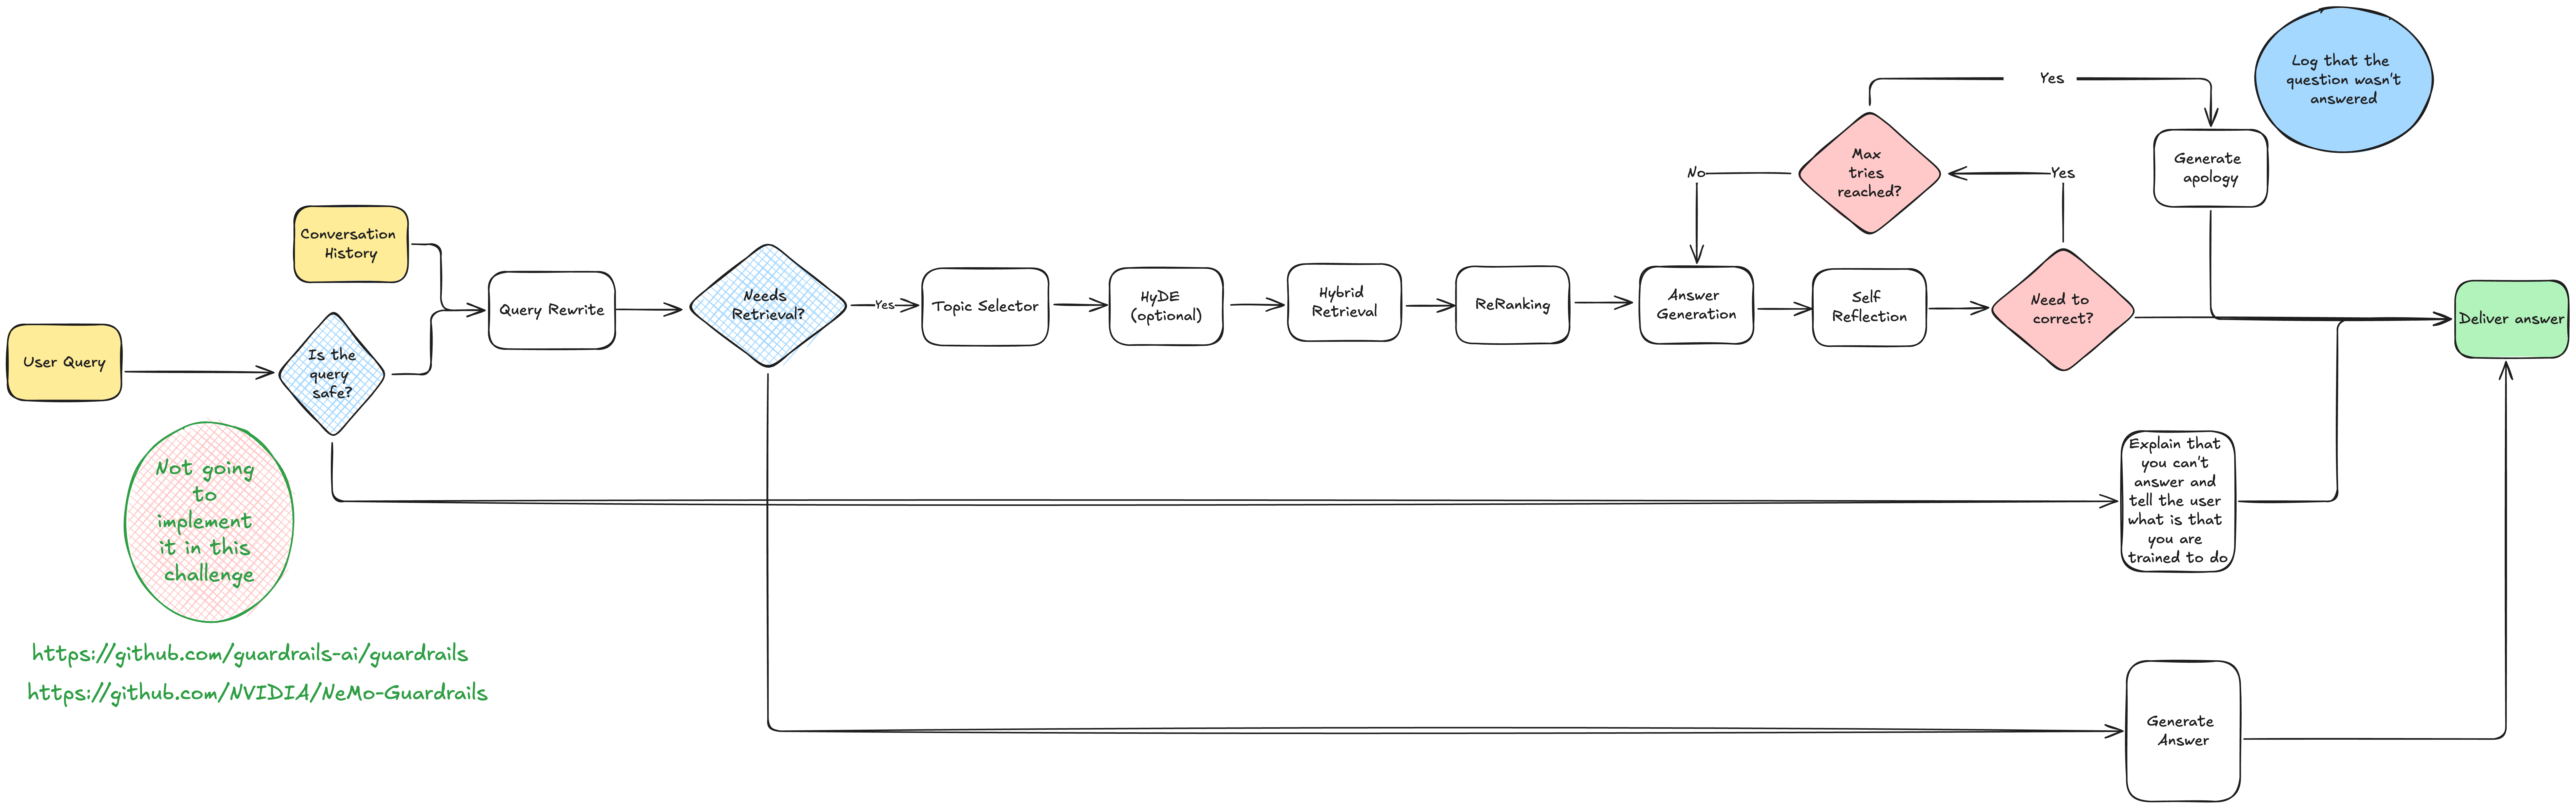

In [18]:
from langchain.retrievers import EnsembleRetriever
from langchain_community.retrievers import TFIDFRetriever
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import OllamaEmbeddings
from langchain_core.retrievers import BaseRetriever
from langchain_ollama import ChatOllama

llm_json_mode = ChatOllama(model="llama3.1:latest", format="json", temperature=0)
llm_generation = ChatOllama(model="llama3.1:latest", temperature=0)

embedding = OllamaEmbeddings(model="nomic-embed-text:latest")  # 768 dims

#TF-IDF
tfidf_retriever = TFIDFRetriever.load_local("tfidf_aoe2.pkl", allow_dangerous_deserialization=True)
tfidf_retriever.k = 2
#Faiss
faiss_retriever = FAISS.load_local("faiss_aoe2", embedding, allow_dangerous_deserialization=True).as_retriever()
faiss_retriever.search_kwargs["k"] = 3

# # initialize the ensemble retriever
retriever = EnsembleRetriever(
    retrievers=[faiss_retriever, tfidf_retriever], weights=[0.75, 0.25]
)

In [19]:
### Retrieval Grader

from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing relevance 
    of a retrieved document to a user question. If the document contains keywords related to the user question, 
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
     <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm_json_mode | JsonOutputParser()
question = "How to build a Town Center?"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

{'score': 'yes'}


In [20]:
### Rewrite query based on chat history


### Generate

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import AIMessage, HumanMessage

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> 
    Given the following chat history and a new question,
    rephrase the question to incorporate the context from the most recent interactions into a brand new query.
    Only output the rephrase question <|eot_id|><|start_header_id|>user<|end_header_id|>
    Chat History: {chat_history} 
    Incoming question: {question} 
    Rephrased question: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["chat_history", "question"],
)


# Chain
rewrite_chain = prompt | llm_generation | StrOutputParser()

# Run
question = "Tell me more?"
docs = retriever.invoke(question)
chat_history = [HumanMessage("How can I build a new Town Center in aoe2?"),
                           AIMessage(content=('To build a new Town Center in Age of Empires 2, advance to the Castle Age '
 'and construct it near a remote resource. For more detailed instructions on '
 'building construction, see Chapter III of the manual.'))]
generation = rewrite_chain.invoke({"chat_history": chat_history, "question": question})
print(generation)

What specific details from Chapter III of the Age of Empires 2 manual should I know about when constructing a Town Center in the Castle Age?


In [21]:
### Generate

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise.  
    Keep you answers brief, make reference to the pages used and keep the answer at 50 words at max.
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Question: {question} 
    Context: {context} 
    Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "document"],
)


# Post-processing
def format_docs(docs):
    context = ""
    for doc in docs:
        context += f"Extracted from page {doc.metadata['page']} \n{doc.page_content} \n\n"
    return context


# Chain
rag_chain = prompt | llm_generation | StrOutputParser()

# Run
question = "How to build a Town Center?"
docs = retriever.invoke(question)
docs = format_docs(docs)
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

To build a Town Center, click on an empty space in your village, then click the "Build" button. You can also create a new villager at the Town Center by clicking on it and selecting "Create Villager". See pages 50-51 for more information.


In [22]:
### Hallucination Grader

# Prompt
prompt = PromptTemplate(
    template=""" <|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether 
    an answer is grounded in / supported by a set of facts. Give a binary 'yes' or 'no' score to indicate 
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a 
    single key 'score' and no preamble or explanation. <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here are the facts:
    \n ------- \n
    {documents} 
    \n ------- \n
    Here is the answer: {generation}  <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm_json_mode | JsonOutputParser()
hallucination_grader.invoke({"documents": docs, "generation": generation})

{'score': 'yes'}

In [23]:
### Answer Grader

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether an 
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is 
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
     <|eot_id|><|start_header_id|>user<|end_header_id|> Here is the answer:
    \n ------- \n
    {generation} 
    \n ------- \n
    Here is the question: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm_json_mode | JsonOutputParser()
answer_grader.invoke({"question": question, "generation": generation})

{'score': 'yes'}

In [24]:
### Router

from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

# LLM

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an expert at routing a 
    user question to a vectorstore or to a chitchat agent. 
    Use the vectorstore for questions or follow up questions (eg: tell me more) on Medieval history and Age of Empires 2 questions.
    It can be about anything related to the game, villager, civilization, building, etc. Take step back and think.
    You do not need to be stringent with the keywords in the question related to these topics. Any related term suffice to use the vectorstore.
    Otherwise, use the chitchat for smalltalk (hey, hello, how are you etc). Give a binary choice 'chitchat' 
    or 'vectorstore' based on the question. Return the a JSON with a single key 'datasource' and 
    no premable or explanation. Question to route: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question"],
)

question_router = prompt | llm_json_mode | JsonOutputParser()
question = "Hey! How are you?"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(question_router.invoke({"question": question}))

question = "How to build a Town Center?"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(question_router.invoke({"question": question}))


question = "How can I build a new Town Center"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(question_router.invoke({"question": question}))

question = "Give me more details"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(question_router.invoke({"question": question}))

{'datasource': 'chitchat'}
{'datasource': 'vectorstore'}
{'datasource': 'vectorstore'}
{'datasource': 'vectorstore'}


In [25]:
### Virtual Agent Prompt

from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

# LLM

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a virtual assistant expert at chitchatting and small talk. 
    Answer the questions asked with a friendly tone. You can help people with their Age of Empires 2 questions.
    Keep it brief, less than 20 words. If you don't know the answer, just say you don't know. Don't make stuff up.
    Chat History: {chat_history} 
    Question: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question"],
)

chitchat = prompt | llm_generation | StrOutputParser()
question = "Hey! How are you?"
print(chitchat.invoke({"question": question, "chat_history":""}))

I'm doing great, thanks for asking! Ready to chat about Age of Empires 2 or anything else you'd like to talk about!


Let's implement the control flow in LangGraph

In [26]:
from pprint import pprint
from typing import List, Any
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages

from langchain_core.documents import Document
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START

### State

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        chit_chat: whether to use or not retrieval
        documents: list of documents
    """

    question: str
    generation: str
    chit_chat: str
    documents: List[str]
    chat_history: List[Any]



### Nodes
def rewrite(state):
    """
    Rewrite a query to 
    """

    question = state["question"]
    chat_history = state["chat_history"]
    if chat_history:
        print("---REWRITE---")
        rewritten_question = rewrite_chain.invoke({"chat_history": chat_history, "question": question})
        question = rewritten_question
        print(f'New question {question}')
    else:
        print("---NO REWRITE NECESSARY---")

    return {"question": question}

def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    documents = format_docs(documents)

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant it will be left out.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    chit_chat = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            # chit_chat = "Yes"
            continue
        
        if len(filtered_docs) == 0:
            chit_chat = "Yes"
            
    return {"documents": filtered_docs, "question": question, "chit_chat": chit_chat}


def chit_chat(state):
    """
    To answer question that don't require retrieval.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---CHITCHAT---")
    question = state["question"]
    chat_history = state["chat_history"]

    # RAG generation
    generation = chitchat.invoke({"question": question, "chat_history":chat_history})
    
    return {"question": question, "generation": generation}

def route_question(state):
    """
    Route question to chitchat or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    # state['question'] = state['messages'][-1]
    question = state["question"]
    print(question)
    source = question_router.invoke({"question": question})
    print(source)
    print(source["datasource"])
    if source["datasource"] == "chitchat":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "chitchat"
    elif source["datasource"] == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"
    

def decide_to_generate(state):
    """
    Determines whether to generate an answer with rag or use chitchat, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    chit_chat = state["chit_chat"]

    if chit_chat == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, ANSWER WITH CHITCHAT---"
        )
        return "chitchat"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score["score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score["score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"


workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("chitchat", chit_chat)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("rewrite", rewrite)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae

In [27]:
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "chitchat":"chitchat",
        "vectorstore":"rewrite"
    }
)

workflow.add_edge('rewrite', 'retrieve')
workflow.add_edge('retrieve', 'grade_documents')
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "chitchat":"chitchat",
        "generate":"generate"
    }
)
workflow.add_edge("chitchat", END)
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "chitchat",
        "useful": END,
        "not useful": "chitchat",
    }
)

In [28]:
# Compile
app = workflow.compile()

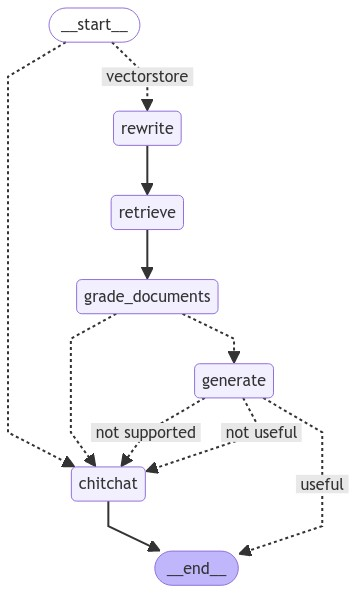

In [29]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

Sample testing

In [30]:
from langchain_core.messages import HumanMessage, AIMessage
# Test

inputs = {"question": "How can I improve my defenses?",
          "chat_history": [HumanMessage("How can I build a new Town Center in aoe2?"),
                           AIMessage(content=('To build a new Town Center in Age of Empires 2, advance to the Castle Age '
                                              'and construct it near a remote resource. For more detailed instructions on '
                                              'building construction, see Chapter III of the manual.')),
                           HumanMessage(content="Give me more details"),
                           AIMessage(content=('For detailed instructions on constructing a Town Center, see Chapter III of '
                                              'the Age of Empires 2 manual.')
                                     )]}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---ROUTE QUESTION---
How can I improve my defenses?
{'datasource': 'vectorstore'}
vectorstore
---ROUTE QUESTION TO RAG---
---REWRITE---
New question You've already built a new Town Center in Age of Empires 2, but now you're looking to fortify your base and improve your defenses. What specific aspects of defense would you like to focus on (e.g. building placement, unit composition, resource management)?
'Finished running: rewrite:'
---RETRIEVE---
'Finished running: retrieve:'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
'Finished running: grade_documents:'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
'Finished running: generate:'
('To fort

In [83]:
from langchain_core.messages import HumanMessage, AIMessage
# Test

inputs = {"question": "Thank you!",
          "chat_history": [HumanMessage("How can I build a new Town Center in aoe2?"),
                           AIMessage(content=('To build a new Town Center in Age of Empires 2, advance to the Castle Age '
                                              'and construct it near a remote resource. For more detailed instructions on '
                                              'building construction, see Chapter III of the manual.')),
                           HumanMessage(content="Give me more details"),
                           AIMessage(content=('For detailed instructions on constructing a Town Center, see Chapter III of '
                                              'the Age of Empires 2 manual.')
                                     )]}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

---ROUTE QUESTION---
Thank you!
{'datasource': 'chitchat'}
chitchat
---ROUTE QUESTION TO WEB SEARCH---
---CHITCHAT---
'Finished running: chitchat:'
("You're welcome! I'm glad I could help with your AoE2 question. If you have "
 'any more, feel free to ask!')


# Evaluation

In [84]:
inputs = {"question": "What is the purpose of using the farm?"}

output = app.invoke(inputs, output_keys=["generation", "documents"])
output['generation']

---ROUTE QUESTION---
What is the purpose of using the farm?
{'datasource': 'vectorstore'}
vectorstore
---ROUTE QUESTION TO RAG---
---NO REWRITE NECESSARY---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---


'The purpose of using a farm is to gather food, which is deposited at the Town Center or Mill. This helps in building up the civilization by providing a source of food for the villagers.'

In [85]:
output.keys()

dict_keys(['generation', 'documents'])

Load the eval dataset

In [86]:
import json
with open("eval.json", 'r') as f:
    eval_dataset = json.load(f)

In [87]:
from tqdm.notebook import tqdm
import json
def run_rag_tests_on_agent(
    app,
    eval_dataset,
    output_file: str,
    verbose = True):
    """Runs RAG tests on the given dataset and saves the results to the given output file."""
    outputs = []

    for example in tqdm(eval_dataset):
        question = example['evalqa']["question"]

        inputs = {"question": question}
        try:
            output = app.invoke(inputs, output_keys=["generation", "documents"], config= {"recursion_limit":10})
            answer = output['generation']
            relevant_docs = output['documents']
        except Exception as e:
            print(e)
            answer = ''
            relevant_docs = []
        
        if verbose:
            print("=======================================================")
            print(f"Question: {question}")
            print(f"Answer: {answer}")
            print(f'True answer: {example['evalqa']["answer"]}')
        result = {
            "question": question,
            "true_answer": example['evalqa']["answer"],
            "source_doc": example["page_content"],
            "generated_answer": answer,
            "retrieved_docs": [doc.page_content for doc in relevant_docs],
            "metadata": [doc.metadata for doc in relevant_docs],
        }

        outputs.append(result)

    with open(output_file, "w") as f:
        json.dump(outputs, f)

In [88]:
run_rag_tests_on_agent(app, eval_dataset, "agent_test.json")

  0%|          | 0/25 [00:00<?, ?it/s]

---ROUTE QUESTION---
What type of camel was known to be an especially experienced warrior and camel rider?
{'datasource': 'vectorstore'}
vectorstore
---ROUTE QUESTION TO RAG---
---NO REWRITE NECESSARY---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
Question: What type of camel was known to be an especially experienced warrior and camel rider?
Answer: The heavy camel was known to be an especially experienced warrior and camel rider. They were used by desert civilizations of the Middle East, particularly the Saracens during the Crusades. Heavy camels excelled at killing other mounted units.
True answer: The heavy camel 

In [89]:
app.invoke({"question":"What countries did the Normans invade besides England in 1066?"}, output_keys=["generation", "documents"])

---ROUTE QUESTION---
What countries did the Normans invade besides England in 1066?
{'datasource': 'vectorstore'}
vectorstore
---ROUTE QUESTION TO RAG---
---NO REWRITE NECESSARY---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
'---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---'
---CHITCHAT---


{'generation': 'The Normans invaded Wales and Ireland in addition to England in 1066!',
 'documents': [Document(metadata={'source': 'docs/Age_of_Empires_2_Manual.pdf', 'page': 86}, page_content='invasion of 1066.  The Normans also invaded Sicily and southern Italy. Many of the Crusades involved sea\nmovement from France to the Holy Land.  The English brought armies into France several times during theHundred Y ear’ s W ar .\nDemolition Ship & Heavy Demolition Ship\nFilled with explosives. Pilot near enemy ships and detonate to wrest\ncontrol of the sea from an entrenched opponent.\n/c66/c117/c105/c108/c116/c32/c97/c116 Dock')]}